In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import choices

In [2]:
# directories and files

base_dir = "/kaggle/input/osic-pulmonary-fibrosis-progression/"
train_csv = base_dir + "train.csv"
test_csv = base_dir + "test.csv"

# read train and test files with pandas
train_db = pd.read_csv(train_csv)
test_db = pd.read_csv(test_csv)

print("Shape of training data: ",train_db.shape, "\n")
print(train_db.head(5))

# unique Patient list
patients = train_db.Patient.unique()

# unique Sex list
sexs = train_db.Sex.unique()

# unique SmokingStatus list
status = train_db.SmokingStatus.unique()

# types of data in each column
print("\n",train_db.dtypes)

# for each object type, determine number of unique values
print("\nNumber of unique Patients: ", len(patients))
print("Number of unique Sexs: ", len(sexs))
print("Number of unique Smoking types: ", len(status), "\n")

print("Sexs: ", sexs)
print("Smoking types: ", status, "\n")

Shape of training data:  (1549, 7) 

                     Patient  Weeks   FVC    Percent  Age   Sex SmokingStatus
0  ID00007637202177411956430     -4  2315  58.253649   79  Male     Ex-smoker
1  ID00007637202177411956430      5  2214  55.712129   79  Male     Ex-smoker
2  ID00007637202177411956430      7  2061  51.862104   79  Male     Ex-smoker
3  ID00007637202177411956430      9  2144  53.950679   79  Male     Ex-smoker
4  ID00007637202177411956430     11  2069  52.063412   79  Male     Ex-smoker

 Patient           object
Weeks              int64
FVC                int64
Percent          float64
Age                int64
Sex               object
SmokingStatus     object
dtype: object

Number of unique Patients:  176
Number of unique Sexs:  2
Number of unique Smoking types:  3 

Sexs:  ['Male' 'Female']
Smoking types:  ['Ex-smoker' 'Never smoked' 'Currently smokes'] 



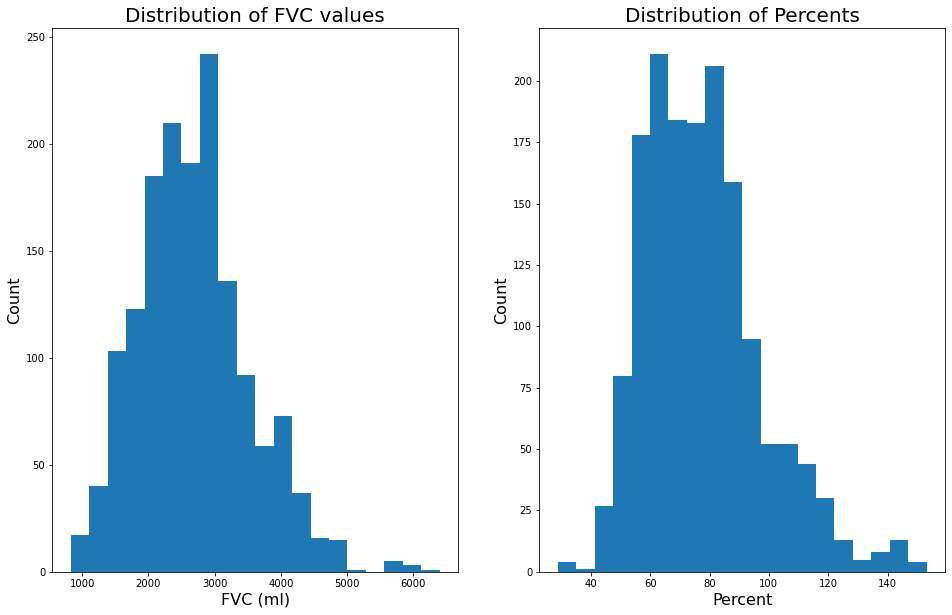

In [3]:
# Histogram of all FVC values

fig, ax = plt.subplots(1,2,figsize=(16, 10))

ax[0].hist(train_db.FVC, bins=20)
ax[0].set_xlabel('FVC (ml)', size=16)
ax[0].set_ylabel('Count', size=16)
ax[0].set_title('Distribution of FVC values', size=20)

ax[1].hist(train_db.Percent, bins=20)
ax[1].set_xlabel('Percent', size=16)
ax[1].set_ylabel('Count', size=16)
ax[1].set_title('Distribution of Percents', size=20)

plt.show()

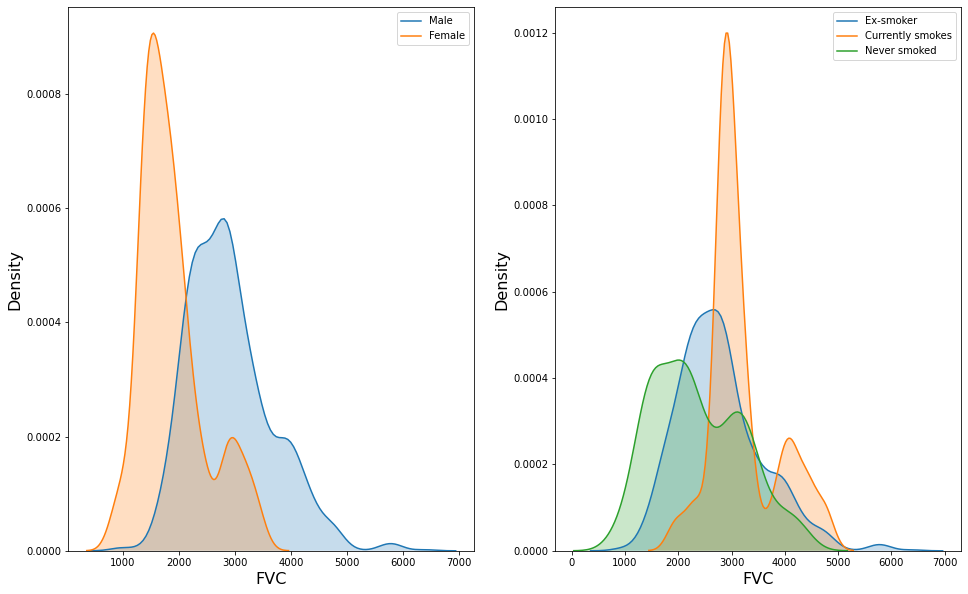

In [4]:
import seaborn as sns

fig, ax = plt.subplots(1, 2, figsize=(16, 10))

# One plot for each different gender
sns.kdeplot(train_db.loc[train_db.Sex=='Male', 'FVC'], label='Male', shade=True, ax=ax[0])
sns.kdeplot(train_db.loc[train_db.Sex=='Female', 'FVC'], label='Female', shade=True, ax=ax[0])
ax[0].set_xlabel('FVC', size=16)
ax[0].set_ylabel('Density', size=16)

# One plot for each type of smoker
sns.kdeplot(train_db.loc[train_db.SmokingStatus=='Ex-smoker', 'FVC'], label='Ex-smoker', shade=True, ax=ax[1])
sns.kdeplot(train_db.loc[train_db.SmokingStatus=='Currently smokes', 'FVC'], label='Currently smokes', shade=True, ax=ax[1])
sns.kdeplot(train_db.loc[train_db.SmokingStatus=='Never smoked', 'FVC'], label='Never smoked', shade=True, ax=ax[1])
ax[1].set_xlabel('FVC', size=16)
ax[1].set_ylabel('Density', size=16)

plt.show()

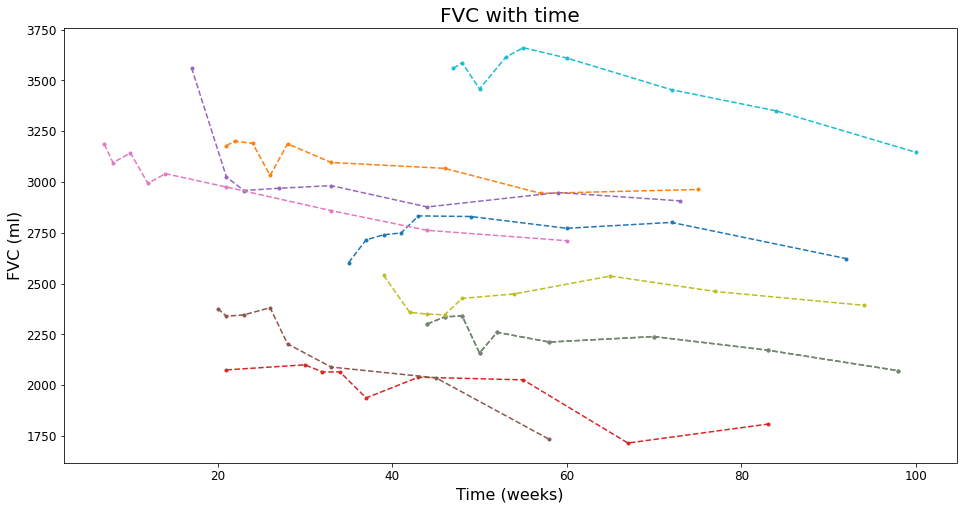

In [5]:
# plot the FVC data as a function of time for k number of patients

fig, ax = plt.subplots(figsize=(16, 8))

for name in choices(patients, k=10):
    week_data = train_db.Weeks.loc[train_db.Patient == name]
    fvc_data = train_db.FVC.loc[train_db.Patient == name]
    ax.plot(week_data, fvc_data, linestyle='--', marker='o', markersize=3)

# axis tick label sizes
ax.tick_params(axis='both', which='major', labelsize=12)

# Set axis labels
ax.set_xlabel('Time (weeks)', size=16)
ax.set_ylabel('FVC (ml)', size=16)
ax.set_title('FVC with time', size=20)

plt.show()

In [6]:
# Find correlations and sort
print("Numeric Variables", train_db.corr()['FVC'].sort_values())

# select categroical varialbes, one hot encode, and place back in FVC values to run correlations
category_df = train_db.select_dtypes('object')
category_df.drop(['Patient'], axis=1, inplace=True)
dummy_df = pd.get_dummies(category_df)
dummy_df['FVC'] = train_db['FVC']

print("\nCategorical Variables\n",dummy_df.corr()['FVC'].sort_values())


# negative weeks and age coefficients suggests that FVC decreases with time as expected
# percent is calculated from FVC and therefore has a high positive correlation

Numeric Variables Age       -0.094125
Weeks     -0.041447
Percent    0.671964
FVC        1.000000
Name: FVC, dtype: float64

Categorical Variables
 Sex_Female                       -0.502915
SmokingStatus_Never smoked       -0.242519
SmokingStatus_Currently smokes    0.146404
SmokingStatus_Ex-smoker           0.161099
Sex_Male                          0.502915
FVC                               1.000000
Name: FVC, dtype: float64


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [7]:
# convert data into Xs and Ys

x = []
y = []

for name in patients:
    x_temp = train_db.loc[train_db.Patient == name]
    for i1, r1 in x_temp.iterrows():
        for i2, r2 in x_temp.iterrows():
            time_change = r2.Weeks - r1.Weeks
            if i1==i2:
                continue
            #elif time_change < -12:
            #    continue
            else:
                x_data = [time_change, r1.FVC, r1.Percent, r1.Age, r1.Sex, r1.SmokingStatus]
                x.append(x_data)
                y.append(r2.FVC)

x = pd.DataFrame(x, columns = ['WeeksChange', 'FVC', 'Percent', 'Age', 'Sex', 'SmokingStatus'])
y = pd.DataFrame(y, columns = ['FVC'])

print(x.shape)
print(y.shape)

x.head(5)

(12158, 6)
(12158, 1)


,WeeksChange,FVC,Percent,Age,Sex,SmokingStatus
0,9,2315,58.253649,79,Male,Ex-smoker
1,11,2315,58.253649,79,Male,Ex-smoker
2,13,2315,58.253649,79,Male,Ex-smoker
3,15,2315,58.253649,79,Male,Ex-smoker
4,21,2315,58.253649,79,Male,Ex-smoker


In [8]:
from sklearn.model_selection import train_test_split

# check if any nan or empty
print(x.isna().sum(), '\n')
print(y.isna().sum(), '\n')

print(x.isnull().sum(), '\n')
print(y.isnull().sum())

# break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(x, y, train_size=0.8, test_size=0.2, random_state=0)

#print(X_train.head(5))


# One-hot encode the data (to shorten the code, we use pandas)
X_train = pd.get_dummies(X_train)
X_valid = pd.get_dummies(X_valid)
X_test = pd.get_dummies(x)
X_train, X_valid = X_train.align(X_valid, join='left', axis=1)
X_train, X_test = X_train.align(X_test, join='left', axis=1)

#print(X_train.head(5))


WeeksChange      0
FVC              0
Percent          0
Age              0
Sex              0
SmokingStatus    0
dtype: int64 

FVC    0
dtype: int64 

WeeksChange      0
FVC              0
Percent          0
Age              0
Sex              0
SmokingStatus    0
dtype: int64 

FVC    0
dtype: int64


In [9]:
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

### Best Models

# Define the models
my_model_xg = XGBRegressor(random_state=0, n_estimators=150, learning_rate=0.1, max_depth=11)
my_model_rf = RandomForestRegressor(random_state=0, n_estimators=65)
my_model_dt = DecisionTreeRegressor(random_state=0, max_depth=14)

# Fit the models
my_model_xg.fit(X_train, y_train, early_stopping_rounds=50, eval_set=[(X_valid, y_valid)], verbose=False)
my_model_rf.fit(X_train, y_train.values.ravel())
my_model_dt.fit(X_train, y_train)

# Get predictions
predictions_xg = my_model_xg.predict(X_valid)
predictions_rf = my_model_rf.predict(X_valid)
predictions_dt = my_model_dt.predict(X_valid)

# Calculate MAE
mae_xg = mean_absolute_error(predictions_xg, y_valid)
mae_rf = mean_absolute_error(predictions_rf, y_valid)
mae_dt = mean_absolute_error(predictions_dt, y_valid)

# average the predictions
avg_predictions = (predictions_xg + predictions_dt + predictions_rf) / 3.0
avg_mae = mean_absolute_error(avg_predictions, y_valid)

print("XGBoost Mean Absolute Error:" , mae_xg)
print("RandomForest Mean Absolute Error:" , mae_rf)
print("DecisionTree Mean Absolute Error:" , mae_dt)
print("Average Mean Absolute Error:", avg_mae)


XGBoost Mean Absolute Error: 101.70746173356709
RandomForest Mean Absolute Error: 105.18065334610564
DecisionTree Mean Absolute Error: 121.36972386647602
Average Mean Absolute Error: 103.69720899205439


In [10]:
# Train the best models using full dataset (i.e. X_test and y)

# Define the models
my_model_xg = XGBRegressor(random_state=0, n_estimators=150, learning_rate=0.1, max_depth=11)
my_model_rf = RandomForestRegressor(random_state=0, n_estimators=65)
my_model_dt = DecisionTreeRegressor(random_state=0, max_depth=14)

# Fit the models
my_model_xg.fit(X_test, y, verbose=False)
my_model_rf.fit(X_test, y.values.ravel())
my_model_dt.fit(X_test, y)

DecisionTreeRegressor(max_depth=14, random_state=0)

In [11]:
x_out = []
y_out = []
patient_id = []
confidence = []

for n in np.arange(-12,134):
    x_tests = []
    
    
    for ind, row in test_db.iterrows():
        
        x_data = [n, row.FVC, row.Percent, row.Age, row.Sex, row.SmokingStatus]
        x_tests.append(x_data)
        
        patient_id.append(row.Patient + '_' + str(n))
        #confidence.append(70)

    
    # add dummy rows to make sure each possible Sex and SmokingStatus is represented
    xmale_ex = [1, -1, 92.0, 70, 'Male', 'Ex-smoker']
    xmale_never = [1, -1, 92.0, 70, 'Male', 'Never smoked']
    xfemale_current = [1, -1, 92.0, 70, 'Female', 'Currently smokes']
    
    x_tests.append(xmale_ex)
    x_tests.append(xmale_never)
    x_tests.append(xfemale_current)
    
    x_tests = pd.DataFrame(x_tests, columns = ['WeeksChange', 'FVC', 'Percent', 'Age', 'Sex', 'SmokingStatus'])
    
    # check if any nan or empty
    #print(x_tests.isna().sum(), '\n')
    #print(x_tests.isnull().sum(), '\n')
    
    # One-hot encode the tests data
    x_tests = pd.get_dummies(x_tests)
    X_train, x_tests = X_train.align(x_tests, join='left', axis=1)
    
    # remove rows with FVC==-1 (the dummy rows)
    x_tests.drop(x_tests[x_tests['FVC']==-1].index, inplace=True)
    
    # Get predictions
    pred_xg = my_model_xg.predict(x_tests)
    pred_rf = my_model_rf.predict(x_tests)
    pred_dt = my_model_dt.predict(x_tests)
    
    # average the predictions
    avg_pred = (pred_xg + pred_dt + pred_rf) / 3.0
    sd = np.sqrt((np.power(pred_xg-avg_pred,2.0) + np.power(pred_rf-avg_pred,2.0) + np.power(pred_dt-avg_pred,2.0)) / 3.0)
    
    #for pred in pred_xg:
    for pred in avg_pred:
        x_out.append(n)
        y_out.append(pred)
    
    for conf in sd:
        confidence.append(conf)

output = {'Patient_Week':patient_id, 'FVC':y_out, 'Confidence': confidence}
output = pd.DataFrame(output)

counter = 0
num_rows = test_db.shape[0]
for ind, row in test_db.iterrows():
    checker = row.Patient + '_' + str(row.Weeks)
    
    # difference between predicted initial value and given value
    diff_fvc = output.loc[output['Patient_Week']==checker, 'FVC'].values[0] - row.FVC
    
    # shift entire column so that the predicted initial value and the given value are equal
    for n in range(12+134):
        val = output.loc[output.index==(counter + n*num_rows), 'FVC'].values[0]
        output.loc[output.index==(counter + n*num_rows), 'FVC'] = val - diff_fvc
    
    output.loc[output['Patient_Week']==checker, 'Confidence'] = 1.0/np.sqrt(2)
    
    counter = counter + 1

print(output.head(10))

# Save output dataframe as csv for submission
output.to_csv('submission.csv', index = False)

                    Patient_Week          FVC  Confidence
0  ID00419637202311204720264_-12  3262.450304  232.876511
1  ID00421637202311550012437_-12  2794.745416   16.399386
2  ID00422637202311677017371_-12  1935.903943   12.259874
3  ID00423637202312137826377_-12  3713.908763  144.940949
4  ID00426637202313170790466_-12  2966.470156    7.397374
5  ID00419637202311204720264_-11  3264.137252  230.694306
6  ID00421637202311550012437_-11  2802.051941   21.571272
7  ID00422637202311677017371_-11  1928.608638    3.816921
8  ID00423637202312137826377_-11  3694.296275  159.810999
9  ID00426637202313170790466_-11  2970.009764    6.127728


Number of test rows:  5
Sorted data shape:  (146, 5)


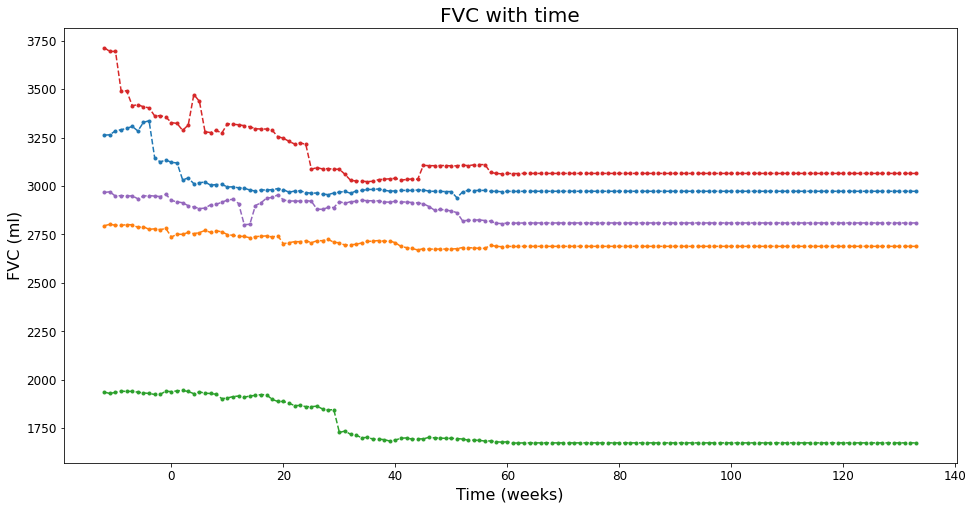

In [12]:
# convert output to easier format and plot results

# number of rows in test.csv file
num_rows = test_db.shape[0]
print("Number of test rows: ", num_rows)

sorted_data = []

for t in range(134+12):
    temp_row = []
    for n in range(num_rows):
        temp_row.append(output.FVC.values[(t*num_rows)+n])
    
    sorted_data.append(temp_row)


sorted_data = np.array(sorted_data)
print("Sorted data shape: ", sorted_data.shape)

times = np.arange(-12,134)


# Plot the results
fig, ax = plt.subplots(figsize=(16, 8))

for n in range(num_rows):
    ax.plot(times,sorted_data[:,n], linestyle='--', marker='o', markersize=3)

    
# axis tick label sizes
ax.tick_params(axis='both', which='major', labelsize=12)

# Set axis labels
ax.set_xlabel('Time (weeks)', size=16)
ax.set_ylabel('FVC (ml)', size=16)
ax.set_title('FVC with time', size=20)

plt.show()

1 / 1


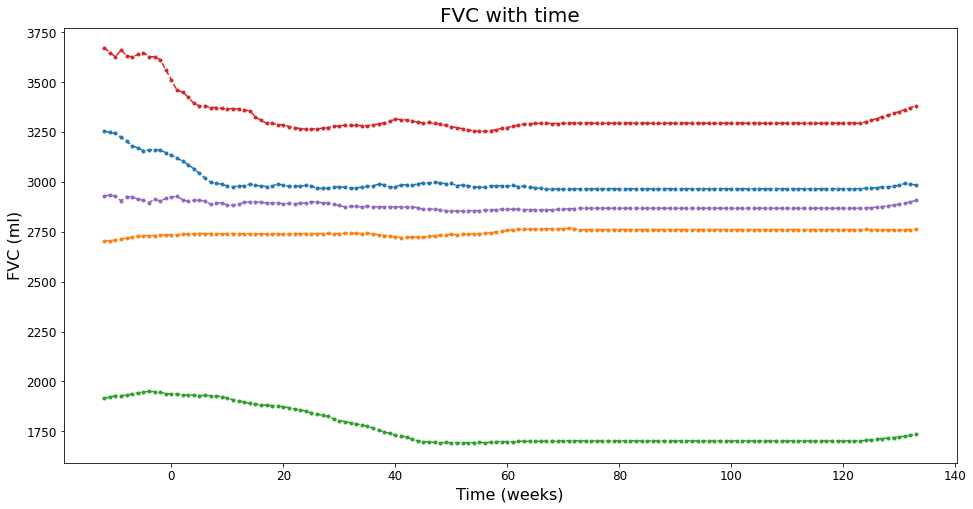

In [13]:
temp_data = np.copy(sorted_data)

# number of iterations
num_iters = 1

for it in range(num_iters):
    
    data_new = np.empty(temp_data.shape)
    sd_new = np.empty(temp_data.shape)
    count = 0

    for ind, row in test_db.iterrows():

        rowf = row.FVC
        rowp = row.Percent
        rowa = row.Age
        rows = row.Sex
        rowss = row.SmokingStatus
        roww = row.Weeks

        for i in range(temp_data.shape[0]):

            t1 = i-12
            x_tests = []


            for j in range(temp_data.shape[0]):

                t2 = j-12
                diff = j-i

                # do not include a point to predict itself
                if i==j:
                    continue

                # do not include points further than some # of weeks away            
                if np.abs(diff)>10:
                    continue

                # do not include the initial point (will include below no matter the number of weeks away)
                if t2==roww:
                    continue

                fvc2 = temp_data[j,count] 

                x_data = [diff, fvc2, rowp, rowa, rows, rowss]
                x_tests.append(x_data)

            # always add initial point no matter the time difference
            diff_org = roww-t1
            x_data = [diff_org, rowf, rowp, rowa, rows, rowss]
            x_tests.append(x_data)


            # add dummy rows to make sure each possible Sex and SmokingStatus is represented
            xmale_ex = [1, -1, 92.0, 70, 'Male', 'Ex-smoker']
            xmale_never = [1, -1, 92.0, 70, 'Male', 'Never smoked']
            xfemale_current = [1, -1, 92.0, 70, 'Female', 'Currently smokes']

            x_tests.append(xmale_ex)
            x_tests.append(xmale_never)
            x_tests.append(xfemale_current)

            x_tests = pd.DataFrame(x_tests, columns = ['WeeksChange', 'FVC', 'Percent', 'Age', 'Sex', 'SmokingStatus'])

            # One-hot encode the tests data
            x_tests = pd.get_dummies(x_tests)
            X_train, x_tests = X_train.align(x_tests, join='left', axis=1)

            # remove rows with FVC==-1 (the dummy rows)
            x_tests.drop(x_tests[x_tests['FVC']==-1].index, inplace=True)

            # Get predictions
            pred_xg = my_model_xg.predict(x_tests)
            #pred_rf = my_model_rf.predict(x_tests)
            #pred_dt = my_model_dt.predict(x_tests)

            # combine predictions with even weighting
            #combined_pred = np.concatenate((pred_xg, pred_rf), axis=0)
            #combined_pred = np.concatenate((combined_pred, pred_dt), axis=0)

            # calculate average prediction and standard deviation
            avg_pred = np.mean(pred_xg)
            sd = np.std(pred_xg)

            data_new[i,count] = avg_pred
            sd_new[i,count] = sd

            if t1==roww:
                #data_new[i,count] = rowf
                sd_new[i,count] = 1.0/np.sqrt(2)
        
        # shift all data so that original point is in correct location
        diff_orig = data_new[roww+12,count] - rowf
        data_new[:,count] = data_new[:,count] - diff_orig
        
        count = count + 1

    temp_data = np.copy(data_new)
    print(it+1,"/",num_iters)

times = np.arange(-12,134)


# Plot the results
fig, ax = plt.subplots(figsize=(16, 8))

for n in range(num_rows):
    ax.plot(times,data_new[:,n], linestyle='--', marker='o', markersize=3)

    
# axis tick label sizes
ax.tick_params(axis='both', which='major', labelsize=12)

# Set axis labels
ax.set_xlabel('Time (weeks)', size=16)
ax.set_ylabel('FVC (ml)', size=16)
ax.set_title('FVC with time', size=20)

# Set axis limits
#ax.set_ylim([1600, 3500])

plt.show()
    

In [14]:
# convert data_new and sd_new into submission file

patient_id2 = []
y_out2 = []
confidence2 = []

for n in np.arange(-12,134):
    count = 0
    for it, row in test_db.iterrows():
        
        patient_id2.append(row.Patient + '_' + str(n))
        y_out2.append(data_new[n,count])
        confidence2.append(sd_new[n,count])
        
        count = count + 1

output2 = {'Patient_Week':patient_id2, 'FVC':y_out2, 'Confidence': confidence2}
output2 = pd.DataFrame(output2)

num_rows = test_db.shape[0]
for ind, row in test_db.iterrows():
    checker = row.Patient + '_' + str(row.Weeks)   
    output2.loc[output2['Patient_Week']==checker, 'Confidence'] = 1.0/np.sqrt(2)


print(output2.head(10))

# Save output2 dataframe as csv for submission
#output2.to_csv('submission.csv', index = False)

                    Patient_Week          FVC  Confidence
0  ID00419637202311204720264_-12  2965.874023   79.657669
1  ID00421637202311550012437_-12  2761.690918    9.621240
2  ID00422637202311677017371_-12  1701.585693   97.820869
3  ID00423637202312137826377_-12  3294.433350  109.654884
4  ID00426637202313170790466_-12  2868.481934   63.576313
5  ID00419637202311204720264_-11  2965.874023   79.657669
6  ID00421637202311550012437_-11  2761.690918    9.621240
7  ID00422637202311677017371_-11  1701.585693   97.820869
8  ID00423637202312137826377_-11  3294.433350  109.654884
9  ID00426637202313170790466_-11  2868.481934   63.576313
